<a href="https://colab.research.google.com/github/victorhss21/projecao_intra_boletos_bacen/blob/main/Proje%C3%A7%C3%A3o_Boleto_Intrabanc%C3%A1rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

---

## 01. Import das bibliotecas

In [314]:
# Análises
!pip install ydata-profiling
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [315]:
# Configurações de visualizações
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 02. Carregamento dos dados

### 02.1 - Instrumentos de Pagamento - Dados Estatisticos (BACEN)

In [316]:
# Carrega dados originais do Bacen
df_bacen = pd.read_excel('Instrumentos de Pagamento - Dados Estatisticos.xlsx', sheet_name="6.3", header=2)
# Extrai array com volume de boletos intrabancários movimentos por ano (Bilhões)
array_bol_intra = df_bacen[df_bacen['Valor (R$ bilhões)'] == 'Boleto de pagamento'].iloc[0,19:].reset_index(drop=True).values
# Extrai array com ano dos volumes de boletos intrabancários movimentos
array_ano = df_bacen[df_bacen['Valor (R$ bilhões)'].isnull()].iloc[0,19:].reset_index(drop=True).values
# Cria dataframe contendo ano e volume de boleto intrabancário movimentado
df_bol_intra = pd.DataFrame({'ano': array_ano, 'vol_bol_intra': array_bol_intra})
# Transforma colunas para os tipos adequados
df_bol_intra['vol_bol_intra'] = pd.to_numeric(df_bol_intra['vol_bol_intra'])
df_bol_intra['ano'] = pd.to_numeric(df_bol_intra['ano'])
df_bol_intra['ano'] = pd.to_datetime(df_bol_intra['ano'], format='%Y')
# Ordena dataframe por ano
df_bol_intra = df_bol_intra.sort_values(by='ano')
# Imprime dataframe
display(df_bol_intra)

,ano,vol_bol_intra
0,2011-01-01,1045.85
1,2012-01-01,1191.92
2,2013-01-01,1330.85
3,2014-01-01,1504.02
4,2015-01-01,1484.98
5,2016-01-01,1424.93
6,2017-01-01,1459.45
7,2018-01-01,2156.93
8,2019-01-01,2431.50
9,2020-01-01,2929.86


# **Análises**
---

## 03. Análise descritiva [[1]](https://towardsdatascience.com/how-to-do-an-eda-for-time-series-cbb92b3b1913)

In [317]:
# Gera pandas profiling report html para overview dos dados
profile = ProfileReport(df_bol_intra, title="Profiling Report", tsmode=True, sortby="ano")
profile.to_file("df_bol_intra_profile_report.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 04. Análise de decomposição [[2]](https://medium.com/@datasciencewizards/preprocessing-and-data-exploration-for-time-series-decomposing-time-series-a44e074c5847)

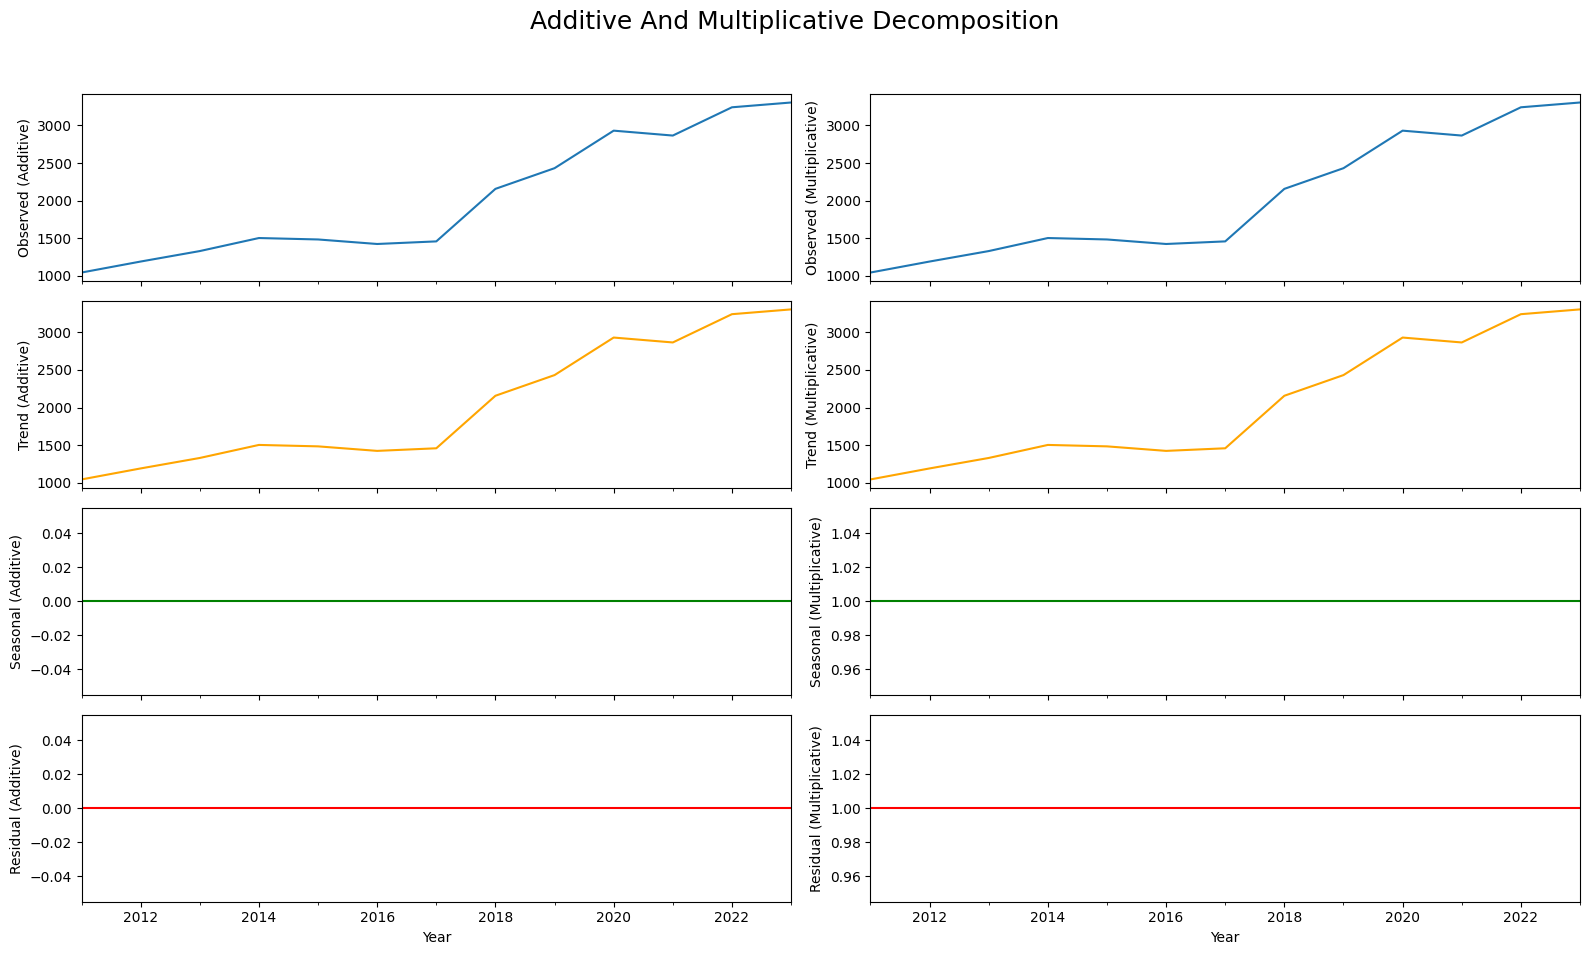

In [318]:
# Convert the year to a datetime index for better time series handling
df = df_bol_intra.set_index('ano')

# Perform additive decomposition
additive_decomp = seasonal_decompose(df['vol_bol_intra'], model='additive')
# Perform multiplicative decomposition
multiplicative_decomp = seasonal_decompose(df['vol_bol_intra'], model='multiplicative')

# Plotting the results
fig, axs = plt.subplots(4, 2, figsize=(16, 10), sharex=True)
additive_decomp.observed.plot(ax=axs[0, 0], legend=False)
axs[0, 0].set_ylabel('Observed (Additive)')
additive_decomp.trend.plot(ax=axs[1, 0], legend=False, color='orange')
axs[1, 0].set_ylabel('Trend (Additive)')
additive_decomp.seasonal.plot(ax=axs[2, 0], legend=False, color='green')
axs[2, 0].set_ylabel('Seasonal (Additive)')
additive_decomp.resid.plot(ax=axs[3, 0], legend=False, color='red')
axs[3, 0].set_ylabel('Residual (Additive)')

multiplicative_decomp.observed.plot(ax=axs[0, 1], legend=False)
axs[0, 1].set_ylabel('Observed (Multiplicative)')
multiplicative_decomp.trend.plot(ax=axs[1, 1], legend=False, color='orange')
axs[1, 1].set_ylabel('Trend (Multiplicative)')
multiplicative_decomp.seasonal.plot(ax=axs[2, 1], legend=False, color='green')
axs[2, 1].set_ylabel('Seasonal (Multiplicative)')
multiplicative_decomp.resid.plot(ax=axs[3, 1], legend=False, color='red')
axs[3, 1].set_ylabel('Residual (Multiplicative)')
axs[3, 0].set_xlabel('Year')
axs[3, 1].set_xlabel('Year')

plt.suptitle('Additive And Multiplicative Decomposition', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Insights:**
* A inexistência de padrões nas componentes de ruído e sazonalidades indicam uma série majoritariamente, se não completamente, descrita pela sua tendência (indicando que **uma estimativa baseada em regressão linear ou mesmo médias móvei, pode não ser uma péssima ideia**).
* A presença de uma **tendência clara indica que pode ser um sinal de um fenômeno subjacente estável e contínuo**, como crescimento econômico, adoção de uma nova tecnologia, ou mudanças demográficas. **Logo, existe oportunidade de explorar correlações com dados macroeconômicos.**
* **A ausência de sazonalidade já era esperada**, dado que estamos trabalhando com dados anuais e **existem pouquíssimos eventos periódicos a cada X anos** (COP30, Copa do Mundo, etc...), além de que a série original não apresenta indícios disso.
* A **ausência de ruído** indica que os dados são **relativamente previsíveis** e não são afetados por grandes variações aleatórias. **Isso pode facilitar a previsão futura e a modelagem dos dados**, já que as flutuações são mínimas.
* Embora a tendência atual seja clara, **é importante monitorar a série para detectar qualquer mudança futura**. Mudanças na tendência podem indicar novos fatores influenciando os dados, como mudanças no mercado (Ex: Mudança na liquidação de boletos), novas tecnologias (Ex: Adoção crescente e contínua do PIX), ou eventos econômicos significativos.
* Quanto a modelagem, dado que não existe sazonolidade ou ruído, **modelos simples (Regressão Linear ou Família ARIMA) podem, possivelmente, trazer bons resultados** sendo suficientes para capturar tendências.



## 05. Análise ACF e PACF [[3]](https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1)

> **Conceitos:**

**Autocorrelation Function (ACF)**

* A Função de Autocorrelação (ACF) mede a **correlação entre a série temporal e suas próprias lags** (valores passados). **Ela inclui tanto a correlação direta quanto indireta**, ou seja, a correlação através de intermediários.
* Quando a série apresenta tendência, a ACF para pequenos lags são usualmente intensos e positivos, dado que observações próximas no tempo também são semelhantes em valores.
* Quando a série apresenta sazonalidade, a ACF apresenta valores intensos para lags correspondentes aos lags sazonais (e múltiplos do período sazonal) comparados a outros lags.
* Séries que apresentam ambos os padrões (tendência e sazonalidade), apresentam uma ACF com ambos efeitos descritos acima combinados.
* A Autocorrelação é matematicamente calculada como:
<center>
$ACF(h) = \frac{Cov(X_{t+h},X_{t})}{\sqrt{Var(X_{t+h})\cdot Var(X_{t})}}$
</center>
em que, $h$ é o lag e o numerador é a covariância (que mede a interdependência entre a série e uma cópia dela com lag $h$). A covarância é expressa por:
<center>
$Cov(X_{t}, X_{t+h}) = \frac{\sum_{}^{}(X_{t}-\overline{X_{t}})(X_{t+h}-\overline{X_{t+h}})}{n}$
</center>

**Partial Autocorrelation Function (ACF)**
* A Função de Autocorrelação Parcial (PACF) mede a **correlação entre dois lags pertencentes a Série Temporal**, mas considera apenas o efeito direto que um certo lag tem sobre o valor do tempo atual.
* Em outras palavras, **a PACF é uma correlação condicional, de forma que calcula a correção da série com uma cópia dela defasa em um lag escohido, desconsiderando o efeito de todos os demais lags** intermediários.
* A Autocorrelação Parcial é matematicamente calculada como:
<center>
$PACF(h) = Cor(X_{t+h},X_{t}|X_{t+1},...,X_{t+h-1})$
</center>

**OBS:**
* A série sem atraso mostra uma autocorrelação perfeita consigo mesma, então lag 0 sempre será 1.
* A faixa azul nos gráficos de ACF e PACF representam o intervalo de confiança: se uma defasagem exceder essa faixa, então ela é estatisticamente significativa e podemos afirmar que ela tem grande importância.
* O Intervalor de confiança é medido pela fórmula $1,96/\sqrt{N}$, em que $N$ é o número de observações da série. Logo, quanto menor o tamanho da série, maior será o intervalo de confiança com considerar uma autocorrelação estatisticamente diferente que zero.




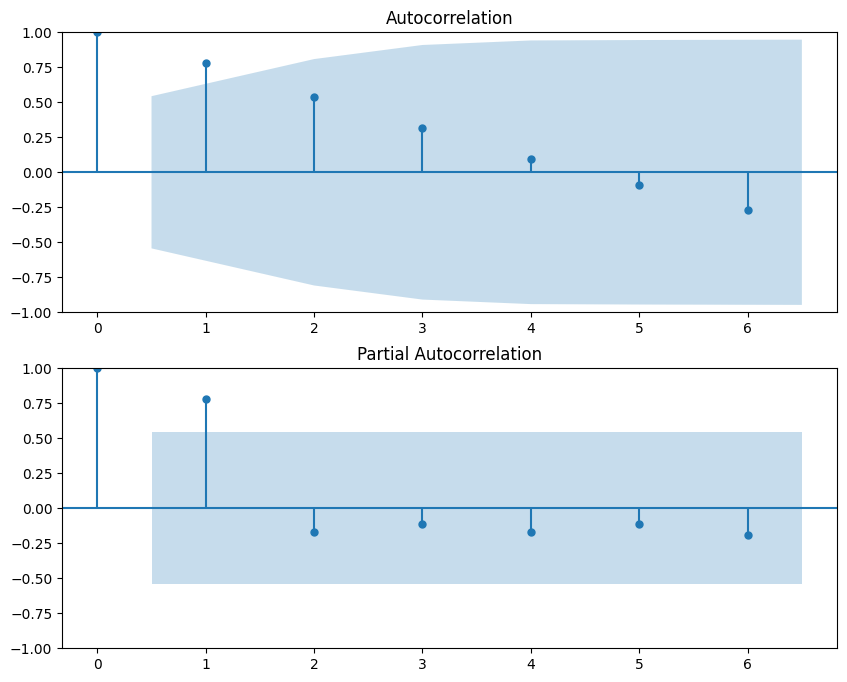

In [319]:
# Plotar ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_bol_intra.set_index('ano')['vol_bol_intra'].values, lags=6, ax=ax[0])
plot_pacf(df_bol_intra.set_index('ano')['vol_bol_intra'].values, lags=6, ax=ax[1])
plt.show()

> **Análise Chat-GPT:**

**Função de Autocorrelação (ACF):**

* Lag 1: A autocorrelação no lag 1 é alta e positiva, indicando que há uma correlação significativa entre o valor do "Boleto Intrabancario" em um ano e o valor no ano anterior.
* Lag 2 a 5: A autocorrelação diminui gradualmente, mas ainda é positiva para os primeiros lags, o que sugere uma dependência temporal, embora enfraquecida, ao longo dos anos.

**Função de Autocorrelação Parcial (PACF):**
* Lag 1: A PACF no lag 1 também é alta e positiva, reforçando a indicação de que o valor do "Boleto Intrabancario" em um ano é fortemente influenciado pelo valor no ano anterior.
* Lag 2 a 5: Os valores de PACF para os lags subsequentes são menores e se aproximam de zero, o que sugere que a maior parte da correlação nos lags maiores pode ser explicada pela correlação no lag 1.

> **Insights - Chat-GPT:**

* Dependência Temporal: Há uma dependência temporal significativa no "Boleto Intrabancario", principalmente de um ano para o outro, conforme evidenciado pela alta autocorrelação no lag 1.
* Modelo AR(1): Os padrões observados tanto na ACF quanto na PACF sugerem que um modelo de autoregressão de ordem 1 (AR(1)) poderia ser apropriado para modelar essa série temporal, já que a PACF mostra uma queda acentuada após o primeiro lag.
* Previsibilidade: A forte correlação de curto prazo (lag 1) indica que os valores do "Boleto Intrabancario" podem ser razoavelmente previstos com base nos valores do ano anterior, mas a previsibilidade diminui para períodos mais longos.

> **Insights - Victor:**

Com bases nos resultados de **ACF**:

- O lag 1, indica que existe uma alta e significativa correlação dos datapoints da série temporal com seus respectivos um ano anterior (lag 1). Ou seja, o 2022 com 2021; 2021 com 2020; assim por diante.
- O lag 2, indica que existe uma moderada, mas não significativa correlação dos datapoints da série temporal com seus respectivos dois anos anteriores (lag 2). Ou seja, o 2022 com 2020; 2021 com 2019; assim por diante.
- O lag 3, indica que existe uma baixa e não significativa correlação dos datapoints da série temporal com seus respectivos três anos anteriores (lag 3). Ou seja, o 2022 com 2019; 2021 com 2018; assim por diante.
- A lenta queda das autocorrelações conforme avançamos nos lags, evidencia a não estacionaridade (média, variância e covariância constantes no tempo) da série e, especialmente, a sua tendência bem explicita!

Com bases nos resultados de **PACF**:

- O lag 1, indica que existe uma alta e significativa correlação do valor de 2022 da série temporal com seu respectivo um ano anterior (lag 1). Ou seja, o 2022 com 2021.
- O lag 2, indica que existe uma baixíssima e não significativa correlação do valor de 2022 da série temporal com seu respectivo segundo ano anterior (lag 2). Ou seja, o 2022 com 2020.
- O lag 3, indica que existe uma moderada e negativa, mas não significativa, correlação do valor de 2022 da série temporal com seu respectivo terceiro ano anterior (lag 3). Ou seja, o 2022 com 2019.

No geral:
- Embora a série temporal possua um número de observações menor que 100 (quantidade ideal na literatura para avaliar ruído branco) [[2]](https://www.youtube.com/watch?v=hIb485TrV-s&list=PLSDVadsSlXTCVcg95hQsEOVRnVwgaPTRC&index=23&pp=iAQB), dado que apresentra lag's na ACF e PACF com autocorrelações distantes o suficiente de zero e também apresenta média diferente de zero, podemos seguir com confiança suficiente de que se não se tratar de um ruído branco, portanto podemos modela-la.

## 06. Análise de Correlação Linear e Não Linear

In [320]:
# TRansforma dataframe em série temporal recenhecida pelo pandas
df_bol_intra_ts = df_bol_intra.set_index('ano')

# função que recebe o dataframe df_bol_intra_ts e retorna um dataframe com 6 lags de vol_bol_intra
def lag_df(df, n_lags):
    lags = range(0,n_lags+1)
    df_lags = df
    for lag in lags:
        df_lags[f'lag_{lag}'] = df['vol_bol_intra'].shift(lag)
    return df_lags#.dropna()

# Executa função
df_bol_intra_ts_lags = lag_df(df_bol_intra_ts,6)

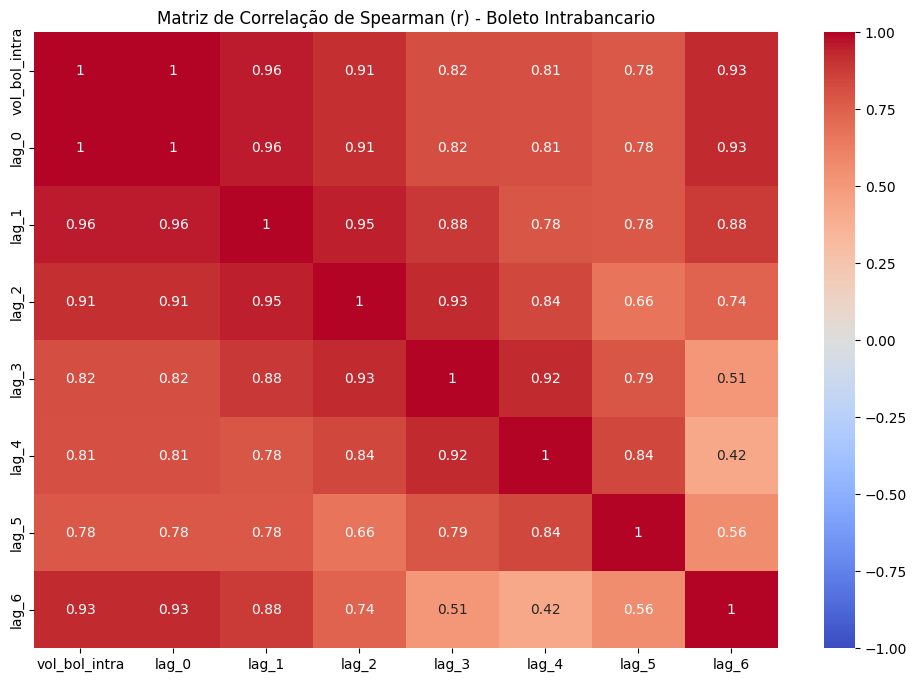

In [321]:
# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df_bol_intra_ts_lags.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Spearman (r) - Boleto Intrabancario')
plt.show()

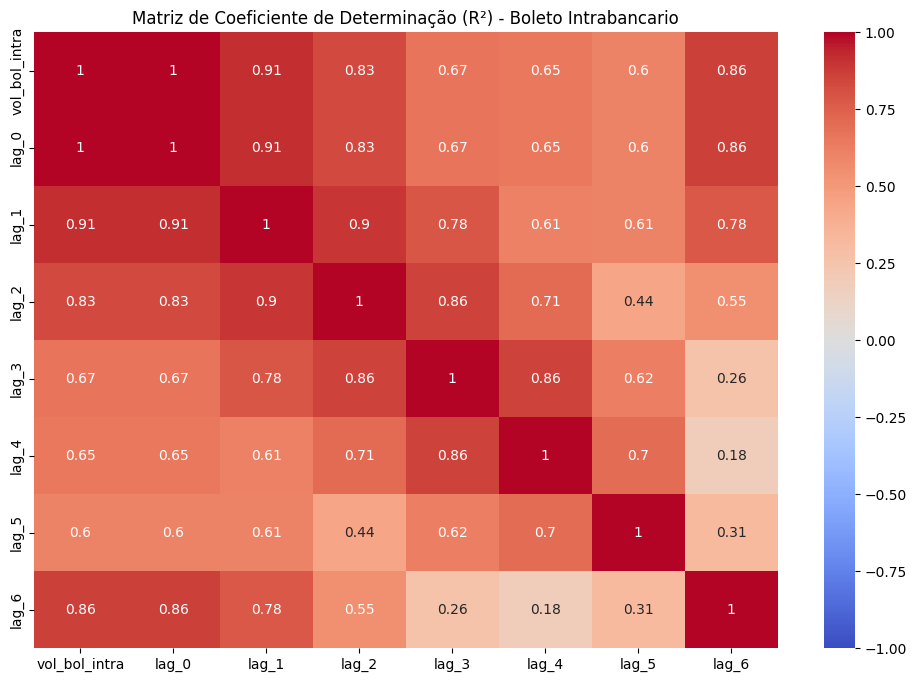

In [322]:
# Plotar a matriz de explicabilidade da variabilidade
plt.figure(figsize=(12, 8))
sns.heatmap(df_bol_intra_ts_lags.corr()**2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Coeficiente de Determinação (R²) - Boleto Intrabancario')
plt.show()

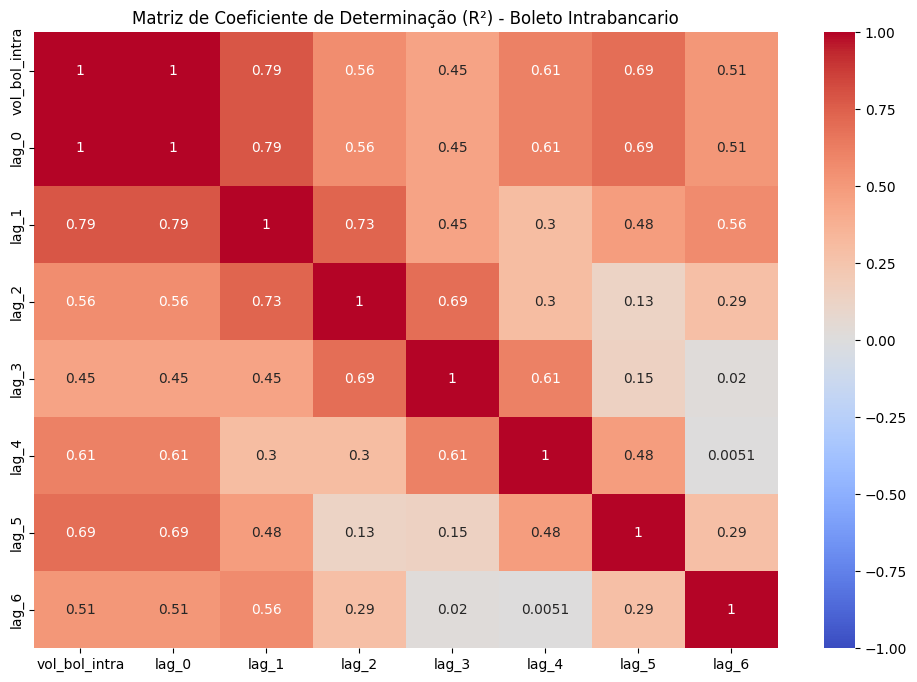

In [323]:
# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df_bol_intra_ts_lags.corr(method='spearman')**2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Coeficiente de Determinação (R²) - Boleto Intrabancario')
plt.show()

> **Insights - Victor:**

* Notavelmente, existe uma forte correlação da série temporal com os seus 6 lags, **indicando que podem ser boas variáveis para um modelo de ML** ou ainda **que modelos da família ARIMA terão bom desempenho no foracasting**
* Ao calcular o R², identificamos que os 2 primeiros lags explicam bastante da variabilidade da série temporal. **Isso é especialmente interessante para o lag 2, dado que a defasagem de disponibilização do BACEN nos impede de utilizar o lag 1 para modelagem**
* Avaliando a correlação de Pearson, fica evidente que a **autocorrelação linear da série é bem mais significativa.**

## 06. Análise de estacionaridade (Talvez)

Embora existam muitos testes estatísticos para assegurar a estacionaridade de uma série temporal, vamos nos preocupar em avaliar 3 critérios práticos:
- Avaliação visual da série temporal e sua média
- Diagrama de Autocorrelação
- Constância no tempo da média, variância e covariância da série (separando a série em 2 dois blocos e os comparando)

Acontece que os teste estatísticos tem pressupostos muito fortes para averiguar questões específicas (fortes) de estacionaridade [[3]](https://www.youtube.com/watch?v=UVGj24c0-LA&list=PLSDVadsSlXTCVcg95hQsEOVRnVwgaPTRC&index=2&pp=iAQB) e em situações reais, onde temos maior complexidade do que os teste podem tratar, vamos seguir avaliando os critérios aciama

Para tornar a série estacionária:
- Primeiro aplicamos o log na série, a fim de deixa-la com um distribuiição normal (aqui, usamos o teste de Shapiro-Wilk para confirmar a normalidade)
- Depois, realizamos a diferenciação (log return) com o lag 1, a fim de remover a tendência da série (se existir)
- Por último, fazemos a diferenciação da série com lag 12, a fim de remover a sazonalidade (se existir)

Para uma séria sem efeito sazonais, sua tendência pode ser descrita pela média móvel da série (dado que a nossa série do BACEN é anual e não apresenta padrões sazonais, dado que é muito comum em séries mensais e menos granulares, pode ser que a média móvel seja uma boa estimativa!)

# C) Pré-processamento

# D) Modelagem

### Sliding Window Cross Validation [[5]](https://youtu.be/g9iO2AwTXyI?t=404)

In [324]:
from posixpath import split
# Definindo função para sliding window
def sliding_window(train, window_size, horizon):
  """
  sliding window generator.
  """
  for i in range(len(train)-window_size-horizon+1):
    split_train = train[i:i+window_size]
    split_test = train[i+window_size:i+window_size+horizon]
    yield split_train, split_test

```python
# Testa função de sliding window
train = np.array([1,2,3,4,5,6,7,8,9,10])

print(f'full training set: {train}')

cv_sliding = sliding_window(train, window_size=4, horizon=1)

i = 0
for cv_train, cv_val in cv_sliding:
  print(f'CV[{i+1}]')
  print(f'training set: {cv_train}')
  print(f'validation set: {cv_val}')
  print('-----')
  i += 1
```

In [325]:
# Define função para realização do cross validation
def cross_validation_score(model, train, cv, metric):
  """
  Calculate cross validation score.
  """
  cv_scores = []
  for cv_train, cv_test in cv:
    model.fit(cv_train)
    preds = model.predict(horizon=len(cv_test))
    score = metric(y_true=cv_test, y_pred=preds)
    cv_scores.append(score)
  return np.array(cv_scores)

### Separação do conjunto de treino

In [326]:
# Define data de corte para validação
data_corte = '2022-01-01'

In [327]:
# Separa em conjunto de treino e teste
train = df_bol_intra.set_index('ano').loc[df_bol_intra.set_index('ano').index < data_corte]
test = df_bol_intra.set_index('ano').loc[df_bol_intra.set_index('ano').index >= data_corte]

```python
# Separa em conjunto de modelagem e validação
modeling = df_bol_intra.set_index('ano').loc[df_bol_intra.set_index('ano').index < data_corte]
validation = df_bol_intra.set_index('ano').loc[df_bol_intra.set_index('ano').index >= data_corte]

# Separa em conjunto de treino e teste
train = modeling.loc[modeling.index <= modeling.index.max() - pd.DateOffset(years=2)]
test = modeling.loc[modeling.index > modeling.index.max() - pd.DateOffset(years=2)]
```

In [328]:
# Separa target e variável explicativa
X_train = train[['vol_bol_intra']].index.year.values
y_train = train['vol_bol_intra'].values
X_test = test[['vol_bol_intra']].index.year.values
y_test = test['vol_bol_intra'].values

### Treinamento do modelo

#### Modelo Híbrido

> A função **DeterministicProcess** é uma ferramenta poderosa para a criação de características determinísticas em séries temporais. Ele simplifica a captura de tendências e componentes sazonais, melhorando a precisão e a robustez dos modelos de previsão.

In [329]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

In [330]:
# Cria objeto que representa o modelo híbrido
class HybridModel:
    def __init__(self, order=1, window_size=4, horizon=2):
        """
        Inicializa o modelo híbrido com os parâmetros fornecidos.

        Parâmetros:
        order (int): Ordem da regressão linear.
        window_size (int): Tamanho da janela de treino.
        horizon (int): Horizonte de previsão.
        """
        self.order = order
        self.window_size = window_size
        self.horizon = horizon
        self.linear_model = LinearRegression(fit_intercept=False)
        self.boost_model = XGBRegressor()

    def fit(self, cv_train, cv_test):
        """
        Treina o modelo híbrido usando os conjuntos de treino e teste fornecidos.

        Parâmetros:
        cv_train (DataFrame): Conjunto de treino.
        cv_test (DataFrame): Conjunto de teste.
        """
        X_train = cv_train.index.year.values.reshape(-1, 1)
        y_train = cv_train.values

        X_test = cv_test.index.year.values.reshape(-1, 1)
        y_test = cv_test.values

        dp = DeterministicProcess(
            index=cv_train.index,
            constant=True,
            order=self.order,
            drop=True)

        X = dp.in_sample()

        self.linear_model.fit(X_train, y_train)

        y_fit = pd.DataFrame(
            self.linear_model.predict(X_train),
            index=cv_train.index,
            columns=cv_train.columns)

        y_pred = pd.DataFrame(
            self.linear_model.predict(X_test),
            index=cv_test.index,
            columns=cv_test.columns)

        y_resid = y_train - y_fit.values

        self.boost_model.fit(X_train, y_resid)

        self.y_fit_boosted = y_fit.values.T + self.boost_model.predict(X_train)
        self.y_pred_boosted = y_pred.values.T + self.boost_model.predict(X_test)

    def predict(self, X_test):
        """
        Realiza previsões usando o conjunto de teste fornecido.

        Parâmetros:
        X_test (DataFrame): Conjunto de teste.

        Retorna:
        y_pred_boosted (DataFrame): Previsões melhoradas pelo modelo.
        """
        X_test_array = X_test.index.year.values.reshape(-1, 1)

        y_pred = pd.DataFrame(
            self.linear_model.predict(X_test_array),
            index=X_test.index,
            columns=X_test.columns)

        y_pred_boosted = y_pred.values.T + self.boost_model.predict(X_test)

        return y_pred_boosted

        # df = pd.DataFrame(
        #   {   'ano':y_pred.index.year.values,
        #       'y_pred_linear': y_pred.values.T[0],
        #       'y_pred_boosted': self.boost_model.predict(X_test)[0],
        #       'y_pred_final': (y_pred.values.T + self.boost_model.predict(X_test))[0]
        #   })

        # return df, y_pred_boosted

```python
# Exemplo de uso da classe HybridModel
cv_sliding = sliding_window(train, window_size=4, horizon=2)

model = HybridModel(order=1, window_size=4, horizon=2)

for cv_train, cv_test in cv_sliding:
    model.fit(cv_train, cv_test)
    predictions = model.predict(cv_test)

    print(cv_test.index.year.values)
    print(predictions)
    print('-----')
```

### Cross Validation

#### Define função de cross validation

In [331]:
# Definindo função de Cross validation para utilização de sliding window

def cross_validation_score(model, train, cv, metric):
  """
  Calculate cross validation score.
  """
  cv_scores = []
  for cv_train, cv_test in cv:
    model.fit(cv_train, cv_test)
    predictions = model.predict(cv_test)
    # score = metric(y_true=cv_test.values.reshape(1, -1), y_pred=predictions)
    score = sqrt(metric(y_true=cv_test.values.reshape(1, -1), y_pred=predictions))
    cv_scores.append(score)
  return np.array(cv_scores)

#### Cross validation no Modelo Híbrido

In [332]:
# Cria daframe para armazenar resultado final
df_cv_score_csld = pd.DataFrame()

# Loop para aplicação do cross validation
for window_size in range(1,9):

  cv_scores = cross_validation_score(model=HybridModel(order=1, window_size=window_size, horizon=2),
                                     train=train,
                                     cv=sliding_window(train, window_size=window_size, horizon=2),
                                     metric=mean_squared_error)

  df_cv_scores = pd.DataFrame(cv_scores).describe().rename(columns={0: f'janela_treino_{window_size}_anos'})

  df_cv_score_csld = pd.concat([df_cv_score_csld, df_cv_scores], axis=1)

In [333]:
# Ajustando Daframe final
df_cv_score_rmse.rename({'count':'train_sample', 'mean':'rmse_mean', 'std':'rmse_std', 'min':'rmse_min', 'max':'rmse_max'}, inplace=True, axis=1)
df_cv_score_rmse  = df_cv_score_rmse[['train_sample','rmse_mean','rmse_std','rmse_min','rmse_max']]
df_cv_score_rmse.sort_values(by='rmse_mean', inplace=True)

display(df_cv_score_rmse)

,train_sample,rmse_mean,rmse_std,rmse_min,rmse_max
janela_treino_1_anos,9.00,348.94,268.63,47.04,844.85
janela_treino_2_anos,8.00,409.87,251.79,65.89,844.86
janela_treino_3_anos,7.00,460.85,233.51,110.14,844.85
janela_treino_4_anos,6.00,511.42,199.15,247.76,844.84
janela_treino_8_anos,2.00,522.33,79.97,465.78,578.88
janela_treino_5_anos,5.00,566.35,171.87,393.12,844.86
janela_treino_6_anos,4.00,620.42,160.06,465.69,844.90
janela_treino_7_anos,3.00,629.83,194.68,465.73,844.93


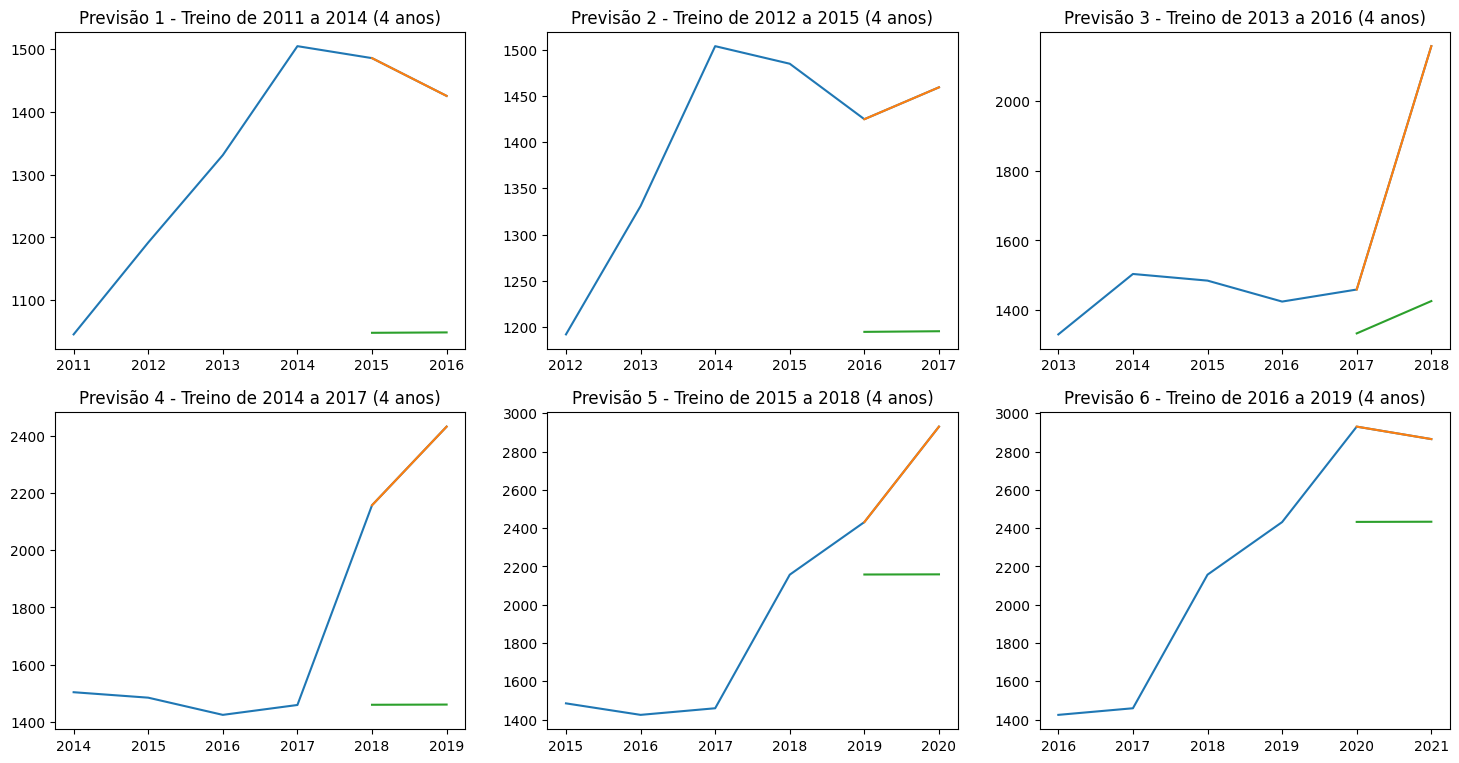

In [252]:
 # Define janela de treinamento
window_size = 4

# Instancia conjuntos para sliding window
cv = sliding_window(train, window_size=window_size, horizon=2)

# Define número de linhas e colunas
n_rows = 3
# n_rows = int(len(list(cv))/2)
n_cols = 3

#definindo o tamanho das figuras
fig = plt.figure(figsize=(18, 14))

# Inicializando variável para contar número de gráficos
idx = 1

# Testa função de sliding window
for cv_train, cv_test in cv:

  # Instancia modelo
  model = HybridModel(order=1, window_size=window_size, horizon=2)

  # Treina modelo
  model.fit(cv_train, cv_test)

  # Realiza previsão
  predictions = model.predict(cv_test)

  # janela de treino
  janela_treino =  f'{cv_train.index.year.values.min()} a {cv_train.index.year.values.max()}'

  # Gráfico
  fig.add_subplot(int(f'{n_rows}{n_cols}{idx}'))
  plt.plot(np.concatenate((cv_train.index.year.values.reshape(-1, 1),cv_test.index.year.values.reshape(-1, 1)), axis=0), np.concatenate((cv_train.values.reshape(-1, 1),cv_test.values.reshape(-1, 1)), axis=0), label='Valores Reais - Treino')
  plt.plot(cv_test.index.year.values.reshape(-1, 1), cv_test.values, label='Valores Reais - Teste')
  plt.plot(cv_test.index.year.values.reshape(-1, 1), predictions.reshape(-1, 1), label='Previsões')
  plt.title(f'Previsão {idx} - Treino de {janela_treino} ({window_size} anos)')
  idx += 1